In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import opensmile
import pandas as pd
#To use OpenSMILE, you may need to have FFmpeg installed on your system. (Check requirements.txt)

In [2]:
dataset_path = 'Dataset'
class_stats = {}
class_gender_speaker_stats = {}
max_duration = 0.0
max_duration_file = ""

# Traverse the dataset directory
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.mp3', '.wav')):
            file_path = os.path.join(root, file)
            class_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file_path))))
            gender_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
            speaker_name = os.path.basename(os.path.dirname(file_path))
            
            # Load the audio file to get its duration
            y, sr = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Update class statistics
            if class_name not in class_stats:
                class_stats[class_name] = {'count': 0, 'duration': 0.0}
            class_stats[class_name]['count'] += 1
            class_stats[class_name]['duration'] += duration
            
            # Update class-gender-speaker statistics
            if class_name not in class_gender_speaker_stats:
                class_gender_speaker_stats[class_name] = {}
            if gender_name not in class_gender_speaker_stats[class_name]:
                class_gender_speaker_stats[class_name][gender_name] = {}
            if speaker_name not in class_gender_speaker_stats[class_name][gender_name]:
                class_gender_speaker_stats[class_name][gender_name][speaker_name] = {'count': 0, 'duration': 0.0}
            class_gender_speaker_stats[class_name][gender_name][speaker_name]['count'] += 1
            class_gender_speaker_stats[class_name][gender_name][speaker_name]['duration'] += duration
            
            # Update maximum duration
            if duration > max_duration:
                max_duration = duration
                max_duration_file = file_path

# Function to format duration in hours, minutes, and seconds
def format_duration(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h {minutes}m {seconds}s"

# Print the statistics
print("Class Statistics:")
for class_name, stats in class_stats.items():
    print(f"{class_name}: {stats['count']} count, {format_duration(stats['duration'])}")

print("\Class Statistics per Speaker and Gender:")
for class_name, genders in class_gender_speaker_stats.items():
    print(f"{class_name}:")
    for gender_name, speakers in genders.items():
        print(f"  {gender_name.capitalize()}:")
        for speaker_name, stats in speakers.items():
            print(f"    {speaker_name}: {stats['count']} count, {format_duration(stats['duration'])}")

#Channel, Speaker Name, Gender, Age, Location, Recording Device        
#C1	G3001	M	15	National Capital Region, Manila	AKG
#C1	G3002	F	15	National Capital Region, Manila	AKG

Class Statistics:
DeepFake: 400 count, 0h 14m 5s
Genuine: 400 count, 0h 29m 0s
\Class Statistics per Speaker and Gender:
DeepFake:
  Female:
    G3002: 200 count, 0h 7m 41s
  Male:
    G3001: 200 count, 0h 6m 23s
Genuine:
  Female:
    G3002: 200 count, 0h 17m 45s
  Male:
    G3001: 200 count, 0h 11m 15s


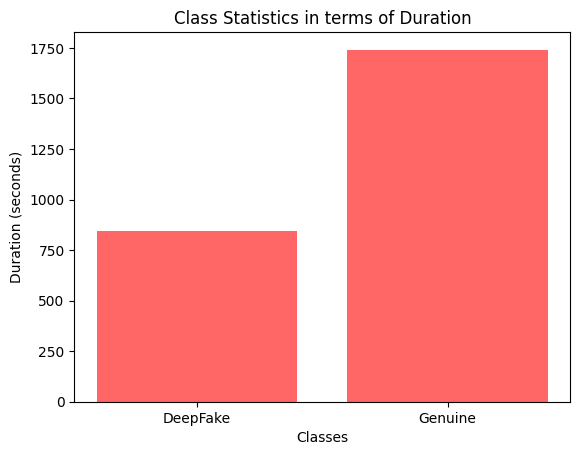

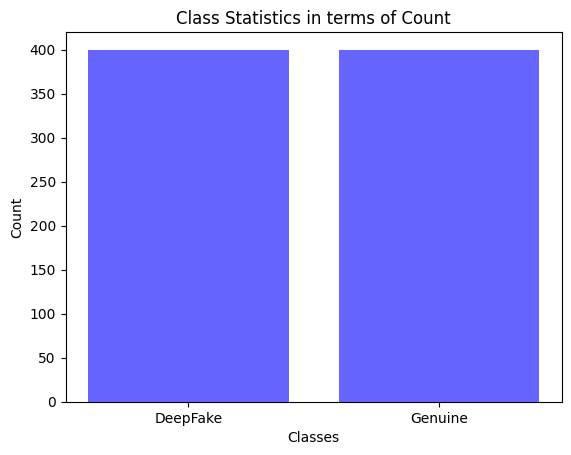

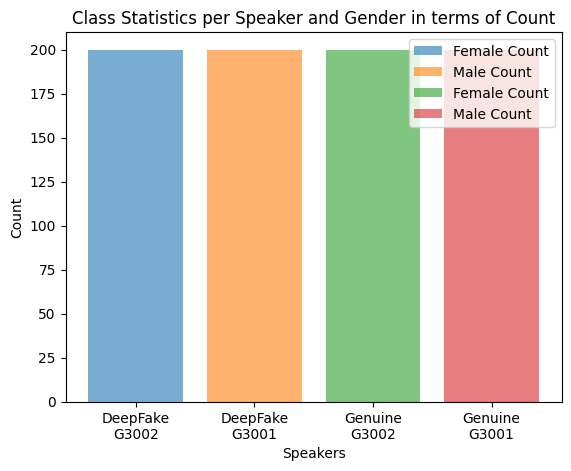

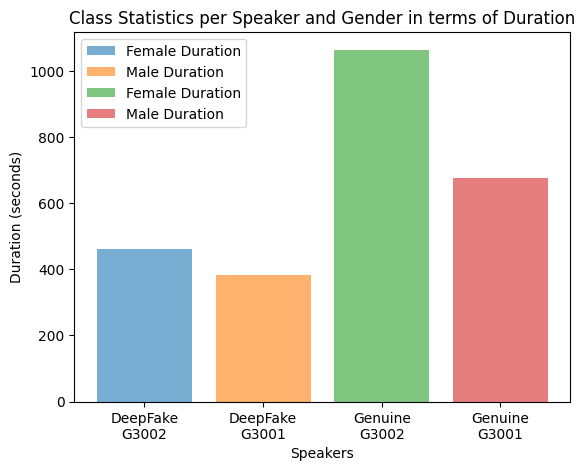

In [3]:
# Plot Main Class Statistics in terms of duration
fig1, ax1 = plt.subplots()
class_names = list(class_stats.keys())
durations = [class_stats[class_name]['duration'] for class_name in class_names]

ax1.bar(class_names, durations, color='r', alpha=0.6)
ax1.set_xlabel('Classes')
ax1.set_ylabel('Duration (seconds)')
ax1.set_title('Class Statistics in terms of Duration')
plt.show()

# Plot Main Class Statistics in terms of count
fig2, ax2 = plt.subplots()
counts = [class_stats[class_name]['count'] for class_name in class_names]

ax2.bar(class_names, counts, color='b', alpha=0.6)
ax2.set_xlabel('Classes')
ax2.set_ylabel('Count')
ax2.set_title('Class Statistics in terms of Count')
plt.show()

# Plot Main Class Statistics per Speaker and Gender in terms of count
fig3, ax3 = plt.subplots()
for class_name, genders in class_gender_speaker_stats.items():
    for gender_name, speakers in genders.items():
        speaker_names = [f"{class_name}\n{speaker_name}" for speaker_name in speakers.keys()]
        counts = [speakers[speaker_name]['count'] for speaker_name in speakers.keys()]
        ax3.bar(speaker_names, counts, alpha=0.6, label=f'{gender_name.capitalize()} Count')
ax3.set_xlabel('Speakers')
ax3.set_ylabel('Count')
ax3.set_title('Class Statistics per Speaker and Gender in terms of Count')
ax3.legend()

plt.show()

# Plot Main Class Statistics per Speaker and Gender in terms of duration
fig4, ax4 = plt.subplots()
for class_name, genders in class_gender_speaker_stats.items():
    for gender_name, speakers in genders.items():
        speaker_names = [f"{class_name}\n{speaker_name}" for speaker_name in speakers.keys()]
        durations = [speakers[speaker_name]['duration'] for speaker_name in speakers.keys()]
        ax4.bar(speaker_names, durations, alpha=0.6, label=f'{gender_name.capitalize()} Duration')
ax4.set_xlabel('Speakers')
ax4.set_ylabel('Duration (seconds)')
ax4.set_title('Class Statistics per Speaker and Gender in terms of Duration')
ax4.legend()

plt.show()

In [4]:
# Define the dataset path and output path
dataset_path = 'Dataset'
output_file = 'OpenSMILE_all_features.csv'

# Initialize OpenSMILE with the updated feature set
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,
    resample=True,
)

# Initialize an empty DataFrame to store all features
all_features = pd.DataFrame()

# Define the target duration in seconds
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.mp3', '.wav')):
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, dataset_path)
            
            # Extract features using OpenSMILE
            features = smile.process_file(file_path)
            
            # Extract label and speaker from the file path
            parts = relative_path.split(os.sep)
            label = 0 if parts[0] == 'DeepFake' else 1
            gender = parts[1]
            speaker = parts[2]

            # Add file information to the features
            features['file'] = file
            features['relative_path'] = relative_path
            features['label'] = label
            features['speaker'] = speaker
            features['gender'] = gender

            # Ensure the columns are in the correct order
            columns_order = ['file', 'relative_path', 'label', 'speaker', 'gender'] + features.columns.drop(['file', 'relative_path', 'label', 'speaker', 'gender']).tolist()
            features = features[columns_order]

            # Append the features to the all_features DataFrame
            all_features = pd.concat([all_features, features], ignore_index=True)

# Save the combined features to a single CSV file
all_features.to_csv(output_file, index=False)